In [1]:
import os

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import cv2



import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Dense , Dropout


# Prepare the Data 

In [2]:
df = pd.read_csv(r'C:\Users\Farouk\Desktop\age-prediction\data\data-interim\labled_UTKFace_image.csv')

In [3]:
df.head()

,id,age
0,0.jpg,100
1,1.jpg,100
2,2.jpg,100
3,3.jpg,100
4,4.jpg,100


C:\Users\Farouk\AppData\Local\Temp\ipykernel_11380\384094377.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_counts.index, y=age_counts.values, palette='viridis')


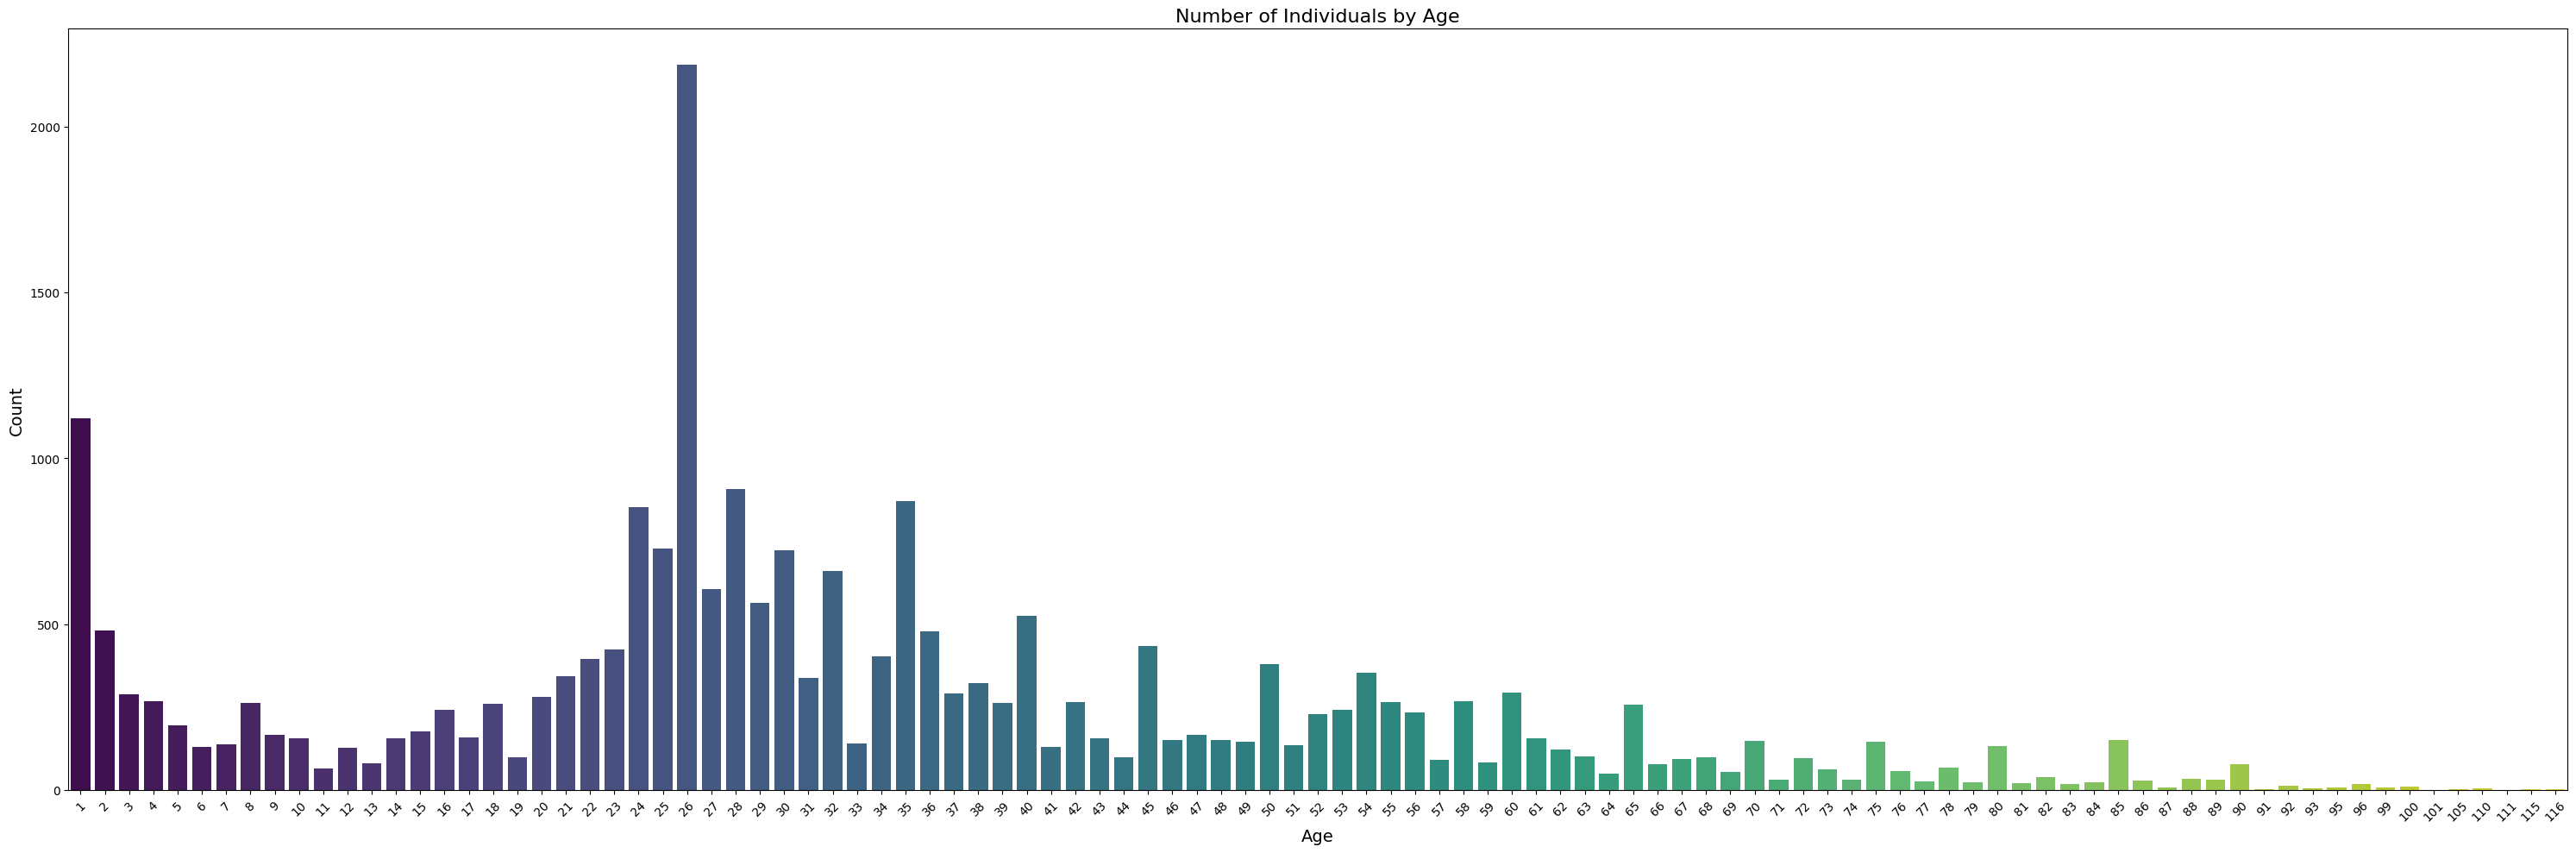

In [4]:
import seaborn as sns 

# Count the number of individuals for each age
age_counts = df['age'].value_counts().sort_index()

# Optionally: Use Seaborn for a more polished look
plt.figure(figsize=(30, 10))
sns.barplot(x=age_counts.index, y=age_counts.values, palette='viridis')
plt.title('Number of Individuals by Age', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###  Load image and labels + Resize images


In [5]:
IMG_SIZE = 128

In [6]:
def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

In [7]:
folder_path = r'C:\Users\Farouk\Desktop\age-prediction\data\data-interim\UTKFace_processed'

List_image_path = []

for image in os.listdir(folder_path):
    image_path = os.path.join(folder_path,image)
    List_image_path .append(image_path)

List_image_path[0]

'C:\\Users\\Farouk\\Desktop\\age-prediction\\data\\data-interim\\UTKFace_processed\\0.jpg'

In [8]:
image_paths = List_image_path
labels = df['age'].values  

In [9]:
labels

array([100, 100, 100, ...,  39,  61,  61])

In [10]:
from sklearn.model_selection import train_test_split

# Séparer en train et test
train_paths, test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


In [11]:
y_train

array([68, 42, 80, ..., 25, 16, 41])

In [12]:
y_test

array([35, 32, 55, ..., 13, 35,  4])

In [13]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [14]:
y_train

array([[68],
       [42],
       [80],
       ...,
       [25],
       [16],
       [41]])

In [15]:
# Charger et prétraiter les images (retourne uniquement l'image)
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)  # Charger l'image depuis le chemin
    img = tf.image.decode_jpeg(img, channels=3)  # Décodez l'image en couleur
    img = tf.image.resize(img, [128, 128])  # Redimensionner l'image
    img = img / 255.0  # Normaliser les pixels
    img.set_shape((IMG_SIZE, IMG_SIZE, 3))
    return img  # Retourne uniquement l'image

In [18]:
# Création du dataset TensorFlow pour l'entraînement
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, y_train))

# Appliquer la fonction de prétraitement uniquement sur les images (les labels sont séparés)
train_dataset = train_dataset.map(lambda image_path, label: (load_and_preprocess_image(image_path), label), num_parallel_calls=tf.data.AUTOTUNE)


In [19]:
# Création du dataset TensorFlow pour le test
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, y_test))

# Appliquer la fonction de prétraitement uniquement sur les images (les labels sont séparés)
test_dataset = test_dataset.map(lambda image_path, label: (load_and_preprocess_image(image_path), label), num_parallel_calls=tf.data.AUTOTUNE)


In [22]:
# Afficher les shapes des données pour vérifier
for x, y in train_dataset.take(1):
    print(f"Image shape: {x.shape}, Label shape: {y.shape}")


Image shape: (128, 128, 3), Label shape: (1,)


# Define a Baseline CNN model

In [29]:
def create_cnn(input_shape=(128, 128, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])
    return model

Avant : loss='mse' → Pénalise fortement les erreurs extrêmes, ce qui peut être un problème avec un dataset déséquilibré.

Après : loss='mae' → Gère mieux les âges sous-représentés et donne une erreur plus stable.

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    patience=5,           # Number of epochs with no improvement before stopping
    restore_best_weights=True,   # Restore the best weights once stopped
    verbose=1              # Display messages when stopping
)


## Config mlflow

In [31]:
import mlflow 
import time 

In [32]:
mlflow.tensorflow.autolog()

In [33]:
mlflow.set_experiment("Age_prediction_Experiment ")

<Experiment: artifact_location='file:///c:/Users/Farouk/Desktop/age-prediction/notebooks/mlruns/985003609896616694', creation_time=1738416687862, experiment_id='985003609896616694', last_update_time=1738416687862, lifecycle_stage='active', name='Age_prediction_Experiment ', tags={}>

## Train the Baseline model ( without Augmentaion )

In [18]:
# Répertoire pour TensorBoard logs
log_dir = "C:/Users/Farouk/Desktop/age-prediction/outputs/logs/fit/" + time.strftime("%Y-%m-%d_%H-%M-%S")
os.makedirs(log_dir, exist_ok=True)

In [19]:
with mlflow.start_run(run_name = "BaselineCNN") : 
    
    model_baseline = create_cnn()
    
    model_baseline.summary()
    
    history = model_baseline.fit(X_train, y_train, 
                                      validation_data=(X_test, y_test),
                                      epochs=30, batch_size=32, callbacks=[early_stopping])    
    
    
    mlflow.keras.log_model(model_baseline, "model")
    
    


c:\Users\Farouk\Desktop\age-prediction\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 16.7480 - mae: 16.7480

588/588 ━━━━━━━━━━━━━━━━━━━━ 117s 189ms/step - loss: 16.7464 - mae: 16.7464 - val_loss: 14.7732 - val_mae: 14.7732
Epoch 2/30
587/588 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 15.5421 - mae: 15.5421

588/588 ━━━━━━━━━━━━━━━━━━━━ 101s 171ms/step - loss: 15.5412 - mae: 15.5412 - val_loss: 14.6349 - val_mae: 14.6349
Epoch 3/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 98s 167ms/step - loss: 15.2776 - mae: 15.2776 - val_loss: 14.7359 - val_mae: 14.7359
Epoch 4/30
587/588 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 15.2353 - mae: 15.2353

588/588 ━━━━━━━━━━━━━━━━━━━━ 100s 170ms/step - loss: 15.2347 - mae: 15.2347 - val_loss: 14.5012 - val_mae: 14.5012
Epoch 5/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 99s 169ms/step - loss: 15.1512 - mae: 15.1512 - val_loss: 14.5071 - val_mae: 14.5071
Epoch 6/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 98s 167ms/step - loss: 14.8081 - mae: 14.8081 - val_loss: 14.6096 - val_mae: 14.6096
Epoch 7/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 97s 166ms/step - loss: 14.7345 - mae: 14.7345 - val_loss: 15.1991 - val_mae: 15.1991
Epoch 8/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 99s 168ms/step - loss: 14.7942 - mae: 14.7942 - val_loss: 14.5716 - val_mae: 14.5716
Epoch 9/30
587/588 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 14.4266 - mae: 14.4266

588/588 ━━━━━━━━━━━━━━━━━━━━ 100s 170ms/step - loss: 14.4270 - mae: 14.4270 - val_loss: 14.4647 - val_mae: 14.4647
Epoch 10/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 98s 166ms/step - loss: 14.3429 - mae: 14.3429 - val_loss: 14.5132 - val_mae: 14.5132
Epoch 11/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 104s 178ms/step - loss: 14.4858 - mae: 14.4858 - val_loss: 14.6627 - val_mae: 14.6627
Epoch 12/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 110s 188ms/step - loss: 14.3353 - mae: 14.3353 - val_loss: 14.4658 - val_mae: 14.4658
Epoch 13/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 106s 180ms/step - loss: 14.0521 - mae: 14.0521 - val_loss: 14.6680 - val_mae: 14.6680
Epoch 14/30
588/588 ━━━━━━━━━━━━━━━━━━━━ 104s 176ms/step - loss: 13.8059 - mae: 13.8059 - val_loss: 15.2379 - val_mae: 15.2379
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


2025/02/02 23:45:26 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/02 23:45:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
